In [1]:
# geral
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
from itertools import product
from multiprocessing import cpu_count

# modeling
# import sktime
# from sktime.utils.load_data import load_from_tsfile_to_dataframe
# from sktime.utils.load_data import load_from_ucr_tsv_to_dataframe
# from sktime.utils.load_data import load_from_arff_to_dataframe
# from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
warnings.simplefilter("ignore")

In [3]:
SEED = 123
NJOBS = cpu_count() - 1

In [4]:
np.random.seed(SEED)

# Goal

The goal of this notebook is to compare different approaches for time series classification for solving a particular problem. In this case, we'll be using the [FordA dataset](http://www.timeseriesclassification.com/description.php?Dataset=FordA) from the [UCR Time Series archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/). 
As explained in the original page:
    
> This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

In particular, this notebook will focus on using two time series libraries: [sktime](https://sktime.org/) and [tsfresh](https://tsfresh.readthedocs.io/en/latest/). They provide different approaches of solving the problem, and the main goal here is to practice both.

# List of Contents
1. [Get Data](#Get-Data)
2. [First inspection](#First-inspection)
3. [Split into training and testing](#Split-into-training-and-testing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [tsfresh](#tsfresh)
5. [sktime](#sktime)
    - [Time Series Forest](#Time-Series-Forest)
    - [Random Interval Spectral Ensemble (RISE)](#Random-Interval-Spectral-Ensemble)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Bag of SFA Symbols (BOSS)](#Bag-of-SFA-Symbols)
    - [Shapelet Transform](#Shapelet-Transform)

# Utility Functions

In [5]:
def to_stacked(df):
    """Reshapes DataFrame of shape (n observations, t timepoints)
    into a stacked format of (n observations * t_timepoints, 3),
    the new columns being `id`, `time` and `value`"""
    
    df.index.name = 'id'
    
    return (df
            .reset_index()
            .melt(id_vars='id', var_name='ts', value_name='value'))

# Get Data

There are some intermediate steps hidden here, that for now will be left missing.

In [6]:
DATA_PATH = '../data/extracted'

In [7]:
data = pd.read_csv(os.path.join(DATA_PATH, "FordA_TRAIN.csv.gz"))
data = data.iloc[:, :-1]

# First inspection

In [8]:
data.head()

,class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [8]:
data.shape

(3601, 501)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, class to 499
dtypes: float64(501)
memory usage: 13.8 MB


Looking at the distribution per time series and some statistics for 20 random samples:

In [18]:
rand_samples = np.random.choice(data.drop('class', axis=1).columns, 20, replace=False).astype(np.int64)

In [19]:
data.drop('class', axis=1).T.loc[:, rand_samples].describe().applymap(lambda x: format(x, '.4f'))

,345,18,297,224,64,370,189,193,31,35,42,286,263,441,103,451,231,291,316,21
count,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000
mean,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.1613,-1.8808,-2.9743,-2.5840,-2.5465,-3.2923,-2.7126,-3.6184,-2.8120,-2.4789,-2.7510,-2.7735,-2.9854,-2.8619,-2.5602,-3.1186,-2.0388,-3.3021,-2.8450,-2.4451
25%,-0.7542,-0.8279,-0.7683,-0.6137,-0.7468,-0.6019,-0.6488,-0.6641,-0.7033,-0.7214,-0.6364,-0.6182,-0.6237,-0.6957,-0.5673,-0.6222,-0.8253,-0.5756,-0.6480,-0.7069
50%,0.0036,-0.0017,0.0555,-0.0176,-0.0036,0.0087,-0.0313,-0.0040,-0.0302,0.0534,0.0110,-0.0496,-0.0256,-0.0170,-0.0839,-0.0029,0.0097,0.0194,0.0266,0.0324
75%,0.7805,0.8085,0.7476,0.6602,0.7456,0.6708,0.7006,0.6978,0.6319,0.7128,0.7095,0.6360,0.7411,0.6939,0.6092,0.6689,0.8039,0.5117,0.7149,0.6764
max,2.0728,2.0102,2.3871,3.1004,2.3301,2.9376,2.7250,2.9720,3.6619,2.5266,2.3631,2.5587,2.5460,3.2215,2.3648,2.5318,2.1759,4.0030,2.8636,2.5988


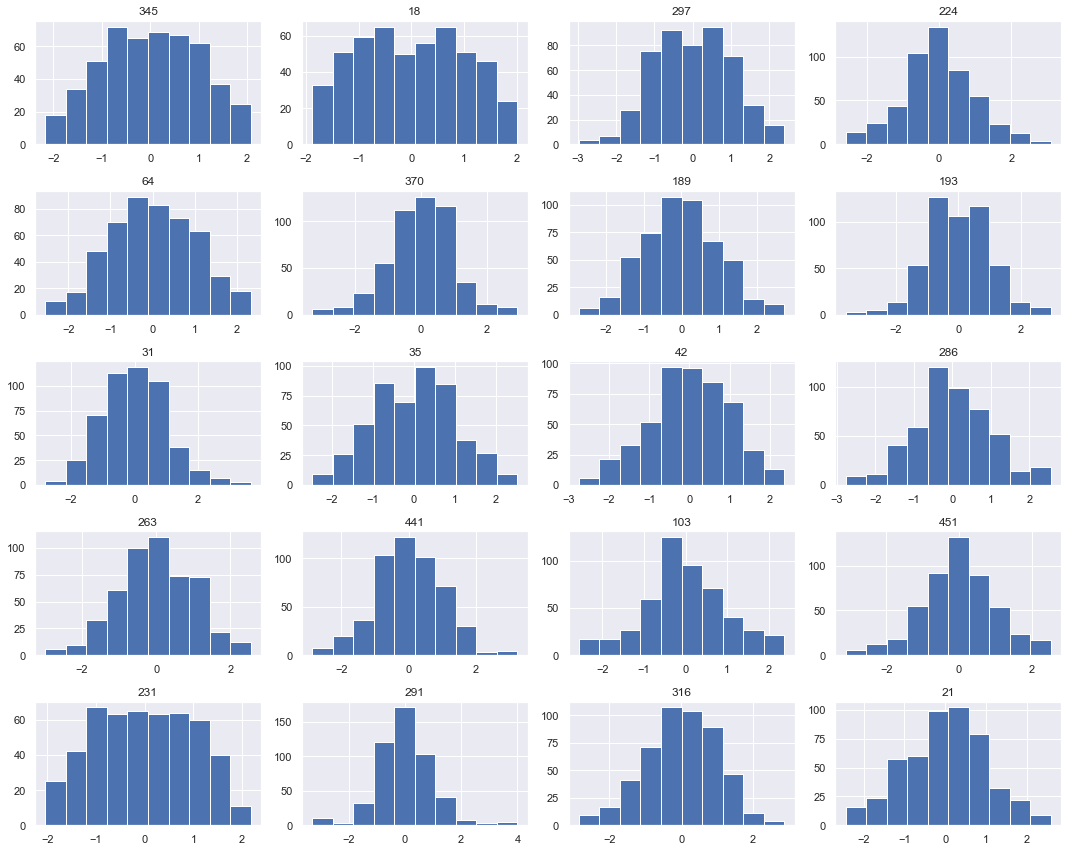

In [20]:
axs = data.drop('class', axis=1).T.loc[:, rand_samples].hist(figsize=(15, 12), layout=(5,4))
plt.tight_layout()
plt.show()

1. Descriptive statistics suggest has been previously standard scaled (mean=0 and standard deviaton = 1). This woudl explain why the data appears to range between -3 and 3.
2. Nonetheless, distribution of data for some observations is not normal.

# Split into training and testing

Before digging deeper, let's split data into training and testing to avoid leaking information in any way.

In [21]:
data.head()

,class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [12]:
data_X = data.drop('class', axis=1)
data_y = data['class']

In [22]:
train_X, test_X, train_y, test_y = (
    train_test_split(data_X, data_y, stratify=data_y,
                     shuffle=True, random_state=SEED)
)

# Exploratory Data Analysis

**Class Distribution**

In [23]:
pd.concat([train_y.value_counts().rename('count'),
           train_y.value_counts(normalize=True).rename('percent')], axis=1)

,count,percent
-1.0,1384,0.512593
1.0,1316,0.487407


Data is fairly balanced.

**Missing and error**

As explained on the source page of the dataset, data consists of 3601 time series, each with 500 time points or measurements (columns 0 to 499), and a classification target.

In [24]:
data.drop('class', axis=1).isna().sum().sum()

0

All time series have the same number of measurements with no missing data.

**Visualization**

For visualization purposes, it's usually easier to deal with data in a "melted", also called stacked or long, format:

In [25]:
train_X_melt = (train_X
               .reset_index()
               .melt(id_vars='index', var_name='ts', value_name='value')
               .set_index(['index', 'ts']))
train_X_melt.head()

,,value
index,ts,
2752,0,1.790104
421,0,-0.197966
505,0,-0.769559
694,0,0.940676
1140,0,0.166898


In [26]:
# sampling positive and negative classes for inspection
idx_positive = train_y[train_y == 1].index.values
idx_negative = train_y[train_y == -1].index.values

n_samples = 10
random_positive_idx = np.random.choice(idx_positive, size=n_samples, replace=False)
random_negative_idx = np.random.choice(idx_negative, size=n_samples, replace=False)

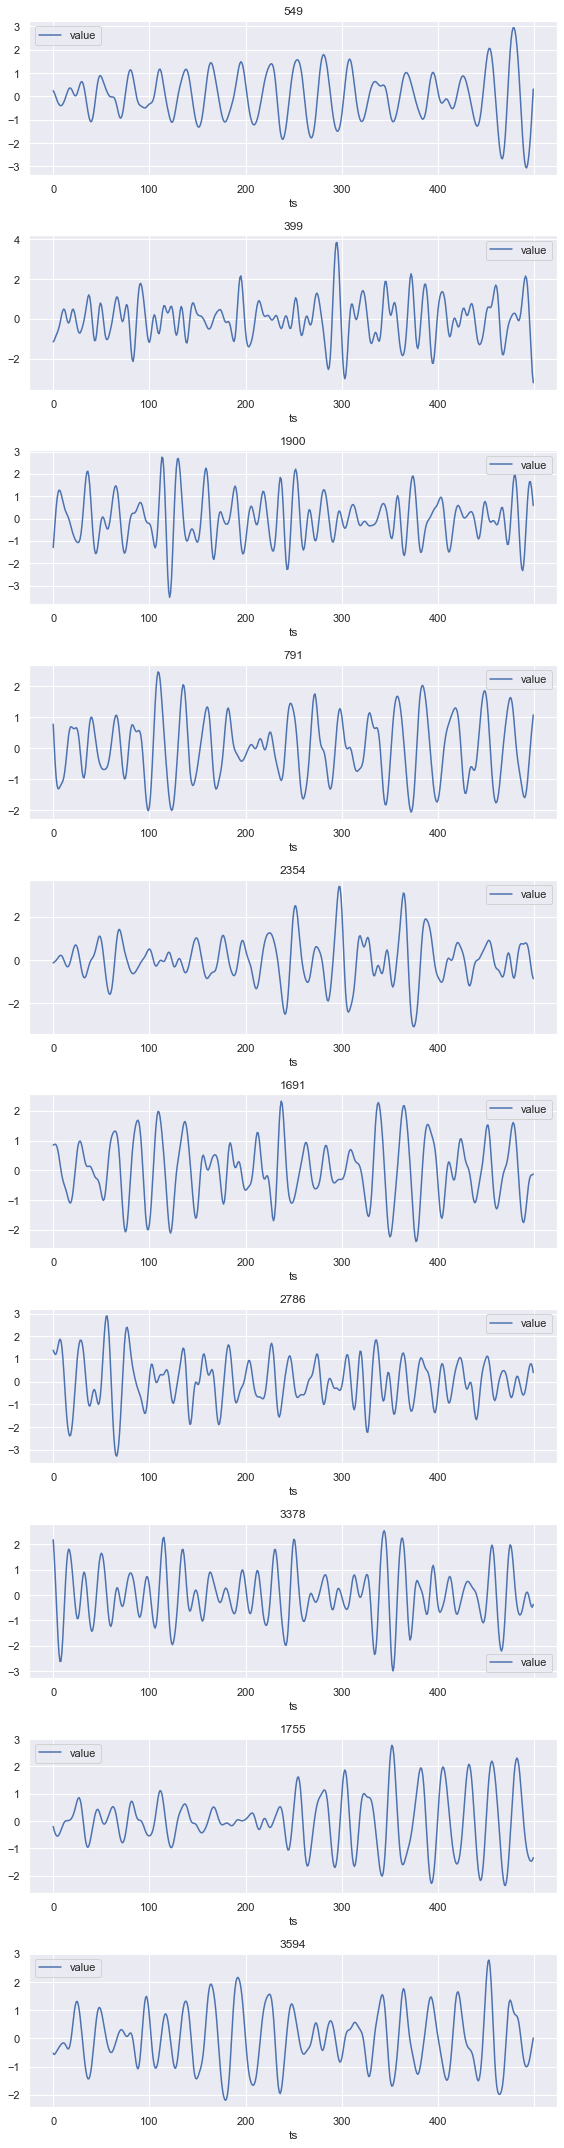

In [27]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_positive_idx):
    train_X_melt.loc[idx].plot(ax=axs[i])
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

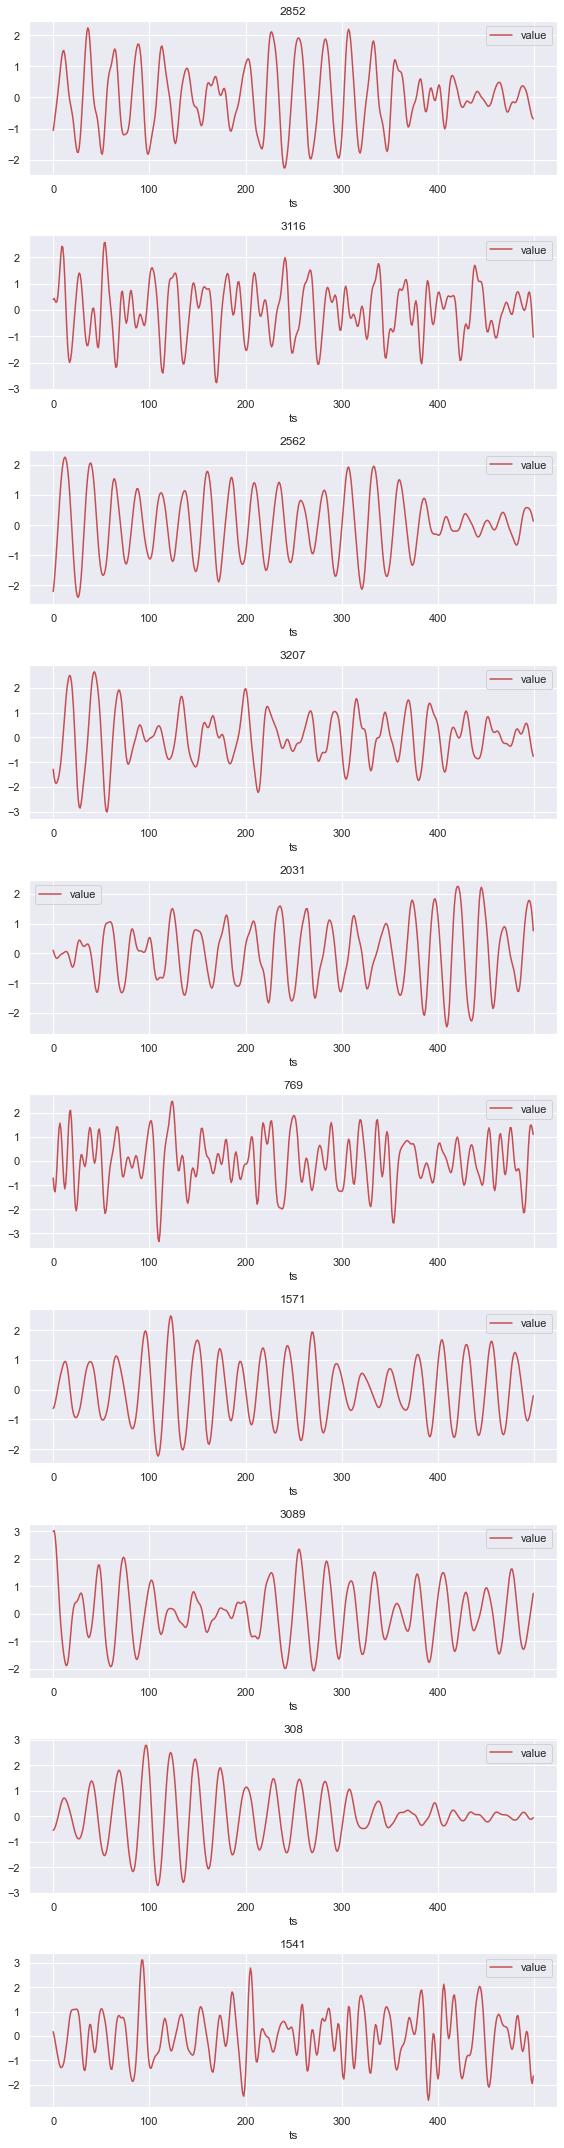

In [28]:
f, axs = plt.subplots(figsize=(8, 3*n_samples), nrows=n_samples)
for i, idx in enumerate(random_negative_idx):
    train_X_melt.loc[idx].plot(ax=axs[i], c='r')
    axs[i].set_title(idx)

plt.tight_layout()
plt.show()

And in terms of distribution, now looking at all of the points in positive and negative classes.

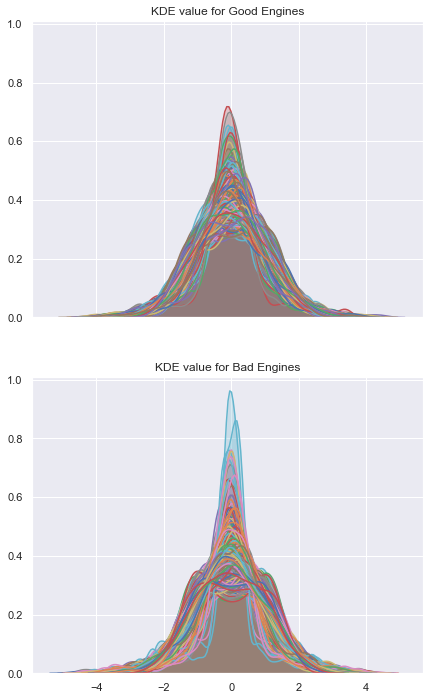

In [29]:
f, axs = plt.subplots(figsize=(7, 12), nrows=2,
                      sharex=True, sharey=True)
for idx in idx_positive:
    sns.distplot(train_X_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[0])
    axs[0].set_title('KDE value for Good Engines')

for idx in idx_negative:
    sns.distplot(train_X_melt.loc[idx], hist=False,
                 kde_kws={'shade': True}, ax=axs[1])
    axs[1].set_title('KDE value for Bad Engines')

plt.show()

**From the graphs**
From this small sample (10 for each class):
- the time series plot doesn't seem to provide an imediate tip as to what contributes for each classification (maybe for a trained specilist it does)
- the kernel density estimation plot seems to show that the distribution for the negative class is somewhat less normal, with some examples being actually bimodal

# tsfresh

`tsfresh`, Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests, is a Python library useful for extracting and selecting features from timeseries data, essentially turning a timeseries with _t_ time points into _n_ features. It's built using Dask, a python library for parallel and distributed computing. This means you can distribute the tasks of extraction and selection across clusters for highly parallelized work, and that even in a single node, tasks can be sent to different cores for faster computations. This is particularly relevant because this library allows you to use its 72 feature calculations, according to their [lisf ot calculated features page](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) at the time of creation of this notebook. These functions, depending on the settings, may yield hundreds of features for a single timeseries. Read more in their [docs page](https://tsfresh.readthedocs.io/en/latest/index.html).

This is one of the approaches for solving the problem that will be displayed here: extracting relevant features from each time series as a whole.

**Note** This library also allows for sliding window creation and computation, but this approach won't be presented in the current notebook.

Necessary imports (made here instead of header for proximity with code and easier check)

In [34]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_selection import select_features
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.utilities.dataframe_functions import impute
from sklearn.preprocessing import StandardScaler

In [33]:
EfficientFCParameters()

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'maximum': None,
 '

tsfresh is able to handle a few [data formats](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html) as inputs. Leveraging the stacked one we already have, we just nees to expose an id column (currently in the index):

In [31]:
train_X_stacked = train_X_melt.copy()
train_X_stacked.index.name = 'id'
train_X_stacked = train_X_melt.reset_index()
train_X_stacked.head()

,index,ts,value
0,2752,0,1.790104
1,421,0,-0.197966
2,505,0,-0.769559
3,694,0,0.940676
4,1140,0,0.166898


And extracting features with tsfresh:

In [32]:
train_X_extr = extract_features(train_X_stacked, column_id='index',
                                column_sort='ts',
                                default_fc_parameters=EfficientFCParameters(),
                                n_jobs=NJOBS)

Feature Extraction: 100%|██████████| 15/15 [08:44<00:00, 34.99s/it]


Save to avoid re-running after.

In [47]:
train_X_extr.to_csv('../data/extracted/tsfresh_efficient_train_X.csv.gz')
train_y.to_csv('../data/extracted/tsfresh_efficient_train_y.csv.gz')

In [44]:
impute(train_X_extr)
assert train_X_extr.isna().sum().sum() == 0

In [39]:
# align index information to make sure rows are consistent
tsfresh_train_X, tsfresh_train_y = train_X_extr.align(train_y, axis=0)

### Feature selection

In [48]:
tsfresh_train_X_selected = select_features(tsfresh_train_X, tsfresh_train_y,
                                           ml_task='classification')
tsfresh_train_X_selected.shape

(2700, 201)

A few steps later, we've extracted 757 features from a single timeseries column of data, imputed missing values and selected relevant features.

In fact, to abstract from all this trouble, `tsfresh` provides scikit-learn transformer-like objects. The code is optimized in order to avoid unnecesary calculations, so it's generally a better idea.

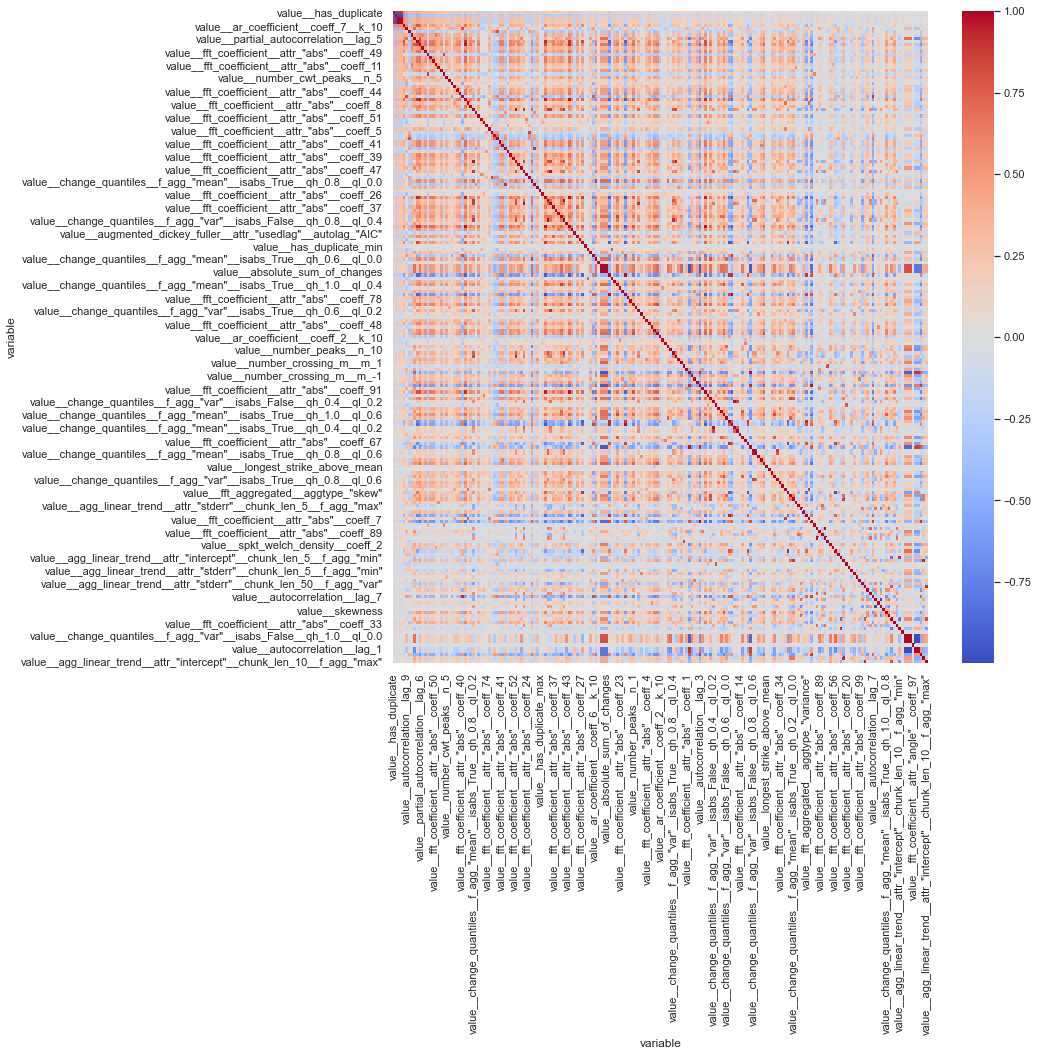

In [69]:
f = plt.figure(figsize=(12,12))
ax = sns.heatmap(tsfresh_train_X_selected.corr(), cmap='coolwarm')
plt.show()

Some colinearity happening. Maybe using a decorrelating technique such as PCA may be handy.

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate

**Feature Scalling**

In [54]:
scaler = MaxAbsScaler()
tsfresh_train_X_scaled = scaler.fit_transform(tsfresh_train_X_selected)

**Inspect dimensions**

In [66]:
n_components = 50
pca = PCA(n_components=n_components)
pca.fit(tsfresh_train_X_scaled)

PCA(n_components=50)

,0,1
0,0.299754,0.299754
1,0.103617,0.403371
2,0.069988,0.473359
3,0.062588,0.535948
4,0.038323,0.574271
5,0.034672,0.608943
6,0.017691,0.626634
7,0.015510,0.642144
8,0.014672,0.656816
9,0.013714,0.670530


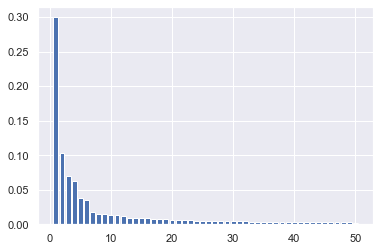

In [67]:
plt.bar(range(1, pca.n_components_+1), pca.explained_variance_ratio_);

explained_var_ratio  = pd.Series(pca.explained_variance_ratio_)
pd.concat([explained_var_ratio, explained_var_ratio.cumsum()], axis=1)

Let's arbitrarily use 26 components (80% of variance ratio explained).

In [70]:
decorrelator = PCA(n_components=26)
tsfresh_train_X_decorrelated = decorrelator.fit_transform(tsfresh_train_X_scaled)

**To actual modelling**

In [76]:
classifier = RandomForestClassifier()

In [78]:
# baseline results using cross validation
cv_results = cross_validate(classifier, tsfresh_train_X_decorrelated, tsfresh_train_y,
                            cv=5, scoring=['f1', 'precision', 'recall'], n_jobs=NJOBS,
                            verbose=2)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.2s finished


In [203]:
for metric in ['test_f1', 'test_precision', 'test_recall']:
    print(f'{metric}: {round(np.mean(cv_results[metric]), 4)}')

test_f1: 0.9834
test_precision: 0.9954
test_recall: 0.9719


### Creating a training Pipeline

In [207]:
test_X_stacked = to_stacked(test_X)

In [209]:
assert (train_X_stacked.columns == test_X_stacked.columns).all()

In [220]:
timeseries_container = pd.concat([train_X_stacked, test_X_stacked]).reset_index(drop=True)

rand_ids = np.random.choice(timeseries_container['id'].unique(), 20, replace=False)
timeseries_container = timeseries_container[timeseries_container['id'].isin(rand_ids)]

In [224]:
train_y = data_y[rand_ids[:15]]
test_y = data_y[rand_ids[15:]]

# X
train_X = pd.DataFrame(index=train_y.index)
test_X = pd.DataFrame(index=test_y.index)

In [231]:
timeseries_container.columns

Index(['id', 'ts', 'value'], dtype='object')

In [225]:
# TODO: automatize pca n_components
pipeline = Pipeline([
    ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='ts', n_jobs=NJOBS)),
#     ('scaler', MaxAbsScaler()),
#     ('reduce_dim', PCA(n_components=26)),
    ('clf', RandomForestClassifier())
])

pipeline.set_params(augmenter__timeseries_container=X_timeseries_container)

X = pd.DataFrame(index=train_ids)
assert (X.index == train_y_first_10.index).all()

In [226]:
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='ts', n_jobs=NJOBS)
augmenter.set_timeseries_container(timeseries_container)

In [ ]:
augmenter.fit(train_X, train_y)

In [238]:
train_X_transformed = augmenter.transform(train_X)

Feature Extraction: 100%|██████████| 15/15 [00:00<00:00, 867.52it/s]


In [239]:
train_X_transformed

""
1734
3134
114
2909
790
1104
3025
1510
134
1196


In [186]:
X_timeseries_container = X_timeseries_container.sort_values(['time']).sort_values(['id'])

In [198]:
X_timeseries_container.reset_index(drop=True, inplace=True)

In [200]:
y = train_y_first_10.sort_index()
X = pd.DataFrame(index=y.index)

In [201]:
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time', column_value='measurement',
                                     ml_task='classification')
augmenter.timeseries_container = X_timeseries_container

In [202]:
augmenter.fit_transform(X, y)

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


""
421
505
694
703
961
1140
2572
2752
2768
2785


In [ ]:
pipeline.set_params(augmenter__timeseries_container=X_timeseries_container)
pipeline.fit(X, y)

In [173]:
pipeline = Pipeline([
    ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time', ml_task='classification')),
    ('scaler', MaxAbsScaler()),
    ('decorralator', PCA(n_components=50)),
    ('classifier', RandomForestClassifier())])

In [177]:
df_ts

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [174]:
df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)

In [175]:
pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.fit(X, y)

Feature Extraction: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id', column_sort='time',
                                          timeseries_container=      id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns])),
                ('scaler', MaxAbsScaler()),
                ('decorralator', PCA(n_components=50)),
                ('classifier', RandomForestClassifier())])

In [130]:
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='ts', n_jobs=NJOBS)

In [132]:
augmenter.set_timeseries_container(X_timeseries_container)

In [134]:
test_augmente_transformed = augmenter.fit_transform(X, train_y_first_10)

Feature Extraction: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


In [135]:
MaxAbsScaler().fit_transform(test_augmente_transformed)

ValueError: at least one array or dtype is required

In [ ]:
pipeline.fit(X, train_y.head(10))

In [ ]:
for metric in ['test_f1', 'test_precision', 'test_recall']:
    print(f'{metric}: {np.mean(cv_results_pl[metric])}')

### Evaluation on test set

In [ ]:
test_X_stacked = to_stacked(test_X)
test_X_stacked.head(20)

## Modelling on tsfresh extracted features

The `tsfresh` library has built-in functionalities for imputation of data and feature selection. The latter is based on hypothesis test procedure called Benjamini Yakutieli (you can learn more on a [notebook](https://github.com/blue-yonder/tsfresh/blob/main/notebooks/advanced/visualize-benjamini-yekutieli-procedure.ipynb) posted on the library's GitHub page).

In order to explore the library, we'll use both procedures here.

In [68]:
impute(tsfresh_test_X);

In [80]:
tsfresh_train_X_selected.shape

(2700, 201)

In [74]:
tsfresh_test_X_selected = tsfresh_test_X.loc[:, tsfresh_train_X_selected.columns]

In [75]:
tsfresh_train_X_scaled = StandardScaler().fit_transform(tsfresh_train_X_selected)

In [77]:
pca = PCA(n_components=2)
tsfresh_train_X_pcs = pca.fit_transform(tsfresh_train_X_scaled)

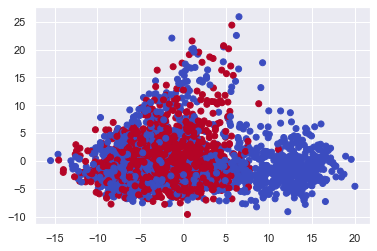

In [92]:
plt.scatter(tsfresh_train_X_pcs[:, 0],
            tsfresh_train_X_pcs[:, 1],
            c=tsfresh_train_y, cmap=plt.cm.get_cmap('coolwarm', 2));

2 components are not enough to separate classes.

<BarContainer object of 50 artists>

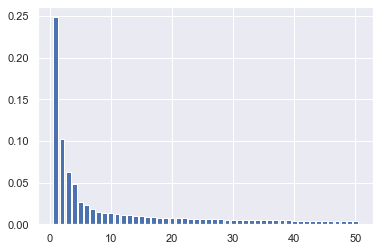

In [94]:
pca = PCA(n_components=50)
pca.fit(tsfresh_train_X_scaled)

plt.bar(range(1, pca.n_components_+1), pca.explained_variance_ratio_)

It seems that the first 4 principal components are the most relevant, and that after that not much information is added.

# sktime

**Get Data in adequate format**

In [13]:
from sktime.utils.data_container import detabularize

In [45]:
X = detabularize(data_X)
y = data_y

In [15]:
assert (X.index == y.index).all()

**Split into training and testing**

In [46]:
train_X, test_X, train_y, test_y = (
    train_test_split(X, y, stratify=y,
                     shuffle=True, random_state=SEED)
)

## Time Series Forest

[List of Contents](#List-of-Contents)

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sktime.series_as_features.compose import FeatureUnion
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor
from sktime.transformers.series_as_features.segment import RandomIntervalSegmenter
from sktime.transformers.series_as_features.compose import RowTransformer
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.utils.time_series import time_series_slope
from sklearn.model_selection import cross_validate

In [18]:
segmenter = RandomIntervalSegmenter(n_intervals='sqrt', random_state=SEED)
transformer = FeatureUnion([
    ('mean', RowTransformer(FunctionTransformer(func=np.mean, validate=False))),
    ('std', RowTransformer(FunctionTransformer(func=np.std, validate=False))),
    ('slope', RowTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
])
classifier = DecisionTreeClassifier()
steps = [
    ('segment', segmenter),
    ('transform', transformer),
    ('clf', classifier)
]

time_series_tree = Pipeline(steps)

Inspecting 1st step output:

In [19]:
train_X_subseq = segmenter.fit_transform(train_X)
type(train_X_subseq)

[[365 450]
 [382 462]
 [322 488]
 [476 478]
 [ 98 308]
 [230 300]
 [ 17 324]
 [ 83 396]
 [106 110]
 [123 465]
 [ 57  98]
 [214 300]
 [225 274]
 [ 96 274]
 [113 250]
 [126 489]
 [ 47 148]
 [ 73 455]
 [ 32 382]
 [430 484]
 [224 439]
 [111 231]]


pandas.core.frame.DataFrame

In [20]:
train_X_subseq

,0_365_450,0_382_462,0_322_488,0_476_478,0_98_308,0_230_300,0_17_324,0_83_396,0_106_110,0_123_465,...,0_225_274,0_96_274,0_113_250,0_126_489,0_47_148,0_73_455,0_32_382,0_430_484,0_224_439,0_111_231
0,"[-1.0173295, -1.0575854, -1.0334118, -0.980904...","[0.98798501, 1.1312536, 1.2017944, 1.1808586, ...","[-0.18756035, 0.025124458, 0.26156556, 0.52492...","[-1.3987485, -1.0282572]","[-0.41455504, -0.29525684, -0.2024308, -0.1471...","[-0.31700431, -0.55723013, -0.77479897, -0.934...","[-1.4984961, -1.3027181, -1.0380089, -0.701136...","[1.2749472, 1.3837527, 1.3806426, 1.256497, 1....","[-0.16733945, -0.12245635, -0.0451, 0.04942546...","[0.15301409, -0.047392461, -0.25704172, -0.448...",...,"[0.66727336, 0.49172988, 0.31636358, 0.1294017...","[-0.67455196, -0.54628762, -0.41455504, -0.295...","[0.30080295, 0.3179422, 0.34232895, 0.38211525...","[-0.44886576, -0.61804894, -0.75938455, -0.874...","[0.064340652, 0.20956048, 0.26188277, 0.221910...","[-1.5274911, -1.4230472, -1.2065267, -0.910587...","[0.52830939, 0.28516425, 0.044359275999999996,...","[-0.04459457, 0.32011186, 0.67851077, 1.006854...","[0.85993751, 0.66727336, 0.49172988, 0.3163635...","[0.2179207, 0.27123179, 0.30080295, 0.3179422,..."
1,"[0.98282451, 0.94969891, 0.73540464, 0.3566131...","[0.44021138, -0.0018125864, -0.43681209, -0.79...","[-0.62814699, -0.85021504, -1.1486695, -1.4379...","[-1.9761924, -1.9742378]","[0.25615762, 0.17217566, 0.049842252999999996,...","[-0.9532288, -0.85333489, -0.62169355, -0.3483...","[-0.52403353, 0.028907142, 0.65790473, 1.23046...","[0.34571878, 0.37480478, 0.38619827, 0.3474776...","[-0.033475752000000004, -0.10918821, -0.243196...","[-2.2808211, -2.543068, -2.4091867000000002, -...",...,"[1.7095366, 0.96680122, 0.20642268, -0.4202406...","[0.15353824, 0.26418271, 0.25615762, 0.1721756...","[0.22046237, 0.74351626, 1.270475, 1.6572058, ...","[-1.9097206000000002, -1.143564, -0.24853292, ...","[-0.6899063, -0.44768159, -0.23617554, -0.0771...","[-0.88457134, -0.77473527, -0.51952784, -0.211...","[-0.95746214, -0.28760485, 0.44197642, 1.09941...","[-1.1742937, -1.1410336, -1.0476276, -0.870133...","[2.2781289, 1.7095366, 0.96680122, 0.20642268,...","[-0.41622451, -0.18657746, 0.22046237, 0.74351..."
2,"[-1.0283939, -0.72004957, -0.42112337, -0.1268...","[-0.058067067, -0.31336771, -0.55331323, -0.78...","[1.6084902, 1.6253776000000002, 1.4905231, 1.2...","[0.28547781, 0.66900891]","[-0.43280654, -0.58009584, -0.71758761, -0.839...","[0.0038432632, 0.12247738, 0.22098395, 0.28212...","[0.20074931, 0.38718708, 0.58994737, 0.7680622...","[-0.91869941, -0.62456922, -0.23863508, 0.1905...","[-0.65093217, -0.44581052, -0.23358612, -0.036...","[-0.079349582, -0.15768647, -0.16326577, -0.11...",...,"[0.070152323, -0.066831816, -0.14276639, -0.15...","[-0.079401322, -0.2685609, -0.43280654, -0.580...","[0.53795877, 0.65869685, 0.76520787, 0.8400641...","[-0.11070285, -0.033379199, 0.03034144, 0.0478...","[0.1206054, -0.4270361, -0.88298015, -1.223950...","[0.43487695, 0.19783319, -0.064794699, -0.3370...","[-2.1159679, -1.7739811, -1.2578951, -0.621460...","[1.6720585, 1.4697121000000002, 1.202340100000...","[0.2443776, 0.070152323, -0.066831816, -0.1427...","[0.27886947, 0.41187998, 0.53795877, 0.6586968..."
3,"[0.38271857, 0.26639724, 0.12051863, -0.045486...","[0.20771104, 0.2925566, 0.3684793, 0.43834727,...","[-0.41731484, -0.2529834, -0.094677599, 0.0513...","[0.26458728, 0.27241012]","[-1.5543283, -1.5213135, -1.4189357, -1.240052...","[-0.95026737, -1.2065983999999998, -1.37125400...","[-0.60186936, -0.35440657, -0.052340069, 0.281...","[1.6345541000000001, 1.548673, 1.3750811, 1.13...","[0.62380748, 1.0540113000000002, 1.44281289999...","[-2.0598768, -2.1801485, -2.1951558999999996, ...",...,"[0.63519564, 0.35454003, 0.042872848, -0.29453...","[-1.4393403999999999, -1.5239731, -1.5543283, ...","[2.0538526999999998, 1.832728, 1.494438, 1.056...","[-2.115119, -1.9474988000000002, -1.703324, -1...","[0.45688804, 0.89867504, 1.25

Then, the original timeseries features (time series in each row) are now transformed into 22 features that correspond to subsequences of the original "raw" timeseries ones.

`(n_observations, 1) -> (n_observations, p_subset_timseries_features)`

Now applying the `RowTransformer` object to extract features from each subset of feaures.

In [21]:
train_X_subseq_transf = transformer.fit_transform(train_X_subseq)
print(type(train_X_subseq_transf))
print(train_X_subseq_transf.shape)
train_X_subseq_transf.head()

<class 'pandas.core.frame.DataFrame'>
(2700, 66)


,0_365_450,0_382_462,0_322_488,0_476_478,0_98_308,0_230_300,0_17_324,0_83_396,0_106_110,0_123_465,...,0_225_274,0_96_274,0_113_250,0_126_489,0_47_148,0_73_455,0_32_382,0_430_484,0_224_439,0_111_231
0,-0.083465,0.044137,0.026378,-1.213503,0.008633,-0.106538,-0.029009,-0.002135,-0.071368,-0.005498,...,-0.000020,-0.000244,-0.000146,0.000270,0.001310,-0.000285,0.000108,-0.016080,0.000733,0.001018
1,0.014075,-0.042915,0.013069,-1.975215,-0.004528,-0.117010,0.010652,0.008278,-0.192732,-0.014802,...,0.010787,0.000210,-0.002070,-0.000012,0.001024,0.000007,-0.000111,-0.002487,-0.000204,0.000737
2,-0.026643,0.024033,0.023421,0.477243,0.009397,-0.096014,-0.012166,-0.018825,-0.341789,0.010690,...,-0.002134,0.000338,-0.002070,0.000198,0.004045,0.000021,0.000195,0.000853,0.000857,-0.001429
3,0.002334,0.027661,0.034520,0.268499,0.027430,-0.128658,0.015398,0.016174,1.221247,-0.008855,...,0.003990,-0.000152,0.001112,-0.000014,0.000331,-0.000093,0.000270,0.004270,0.000366,0.000839
4,-0.011878,0.041257,0.062237,2.235712,0.029363,-0.013526,-0.000040,-0.001529,-0.747664,-0.004442,...,0.012002,0.000124,-0.000072,0.000402,0.000607,0.000192,0.000244,0.023190,0.000842,-0.001068


As we've passed 22 timeseries_subsequences as features, and requested the object to compute 3 calculations over each (mean, std, slope), it follows that we get now 66 (22 * 3) columns.

**Notice** how now they are values as features (not anymore timeseries subsequences as features).

Now these features are in a common ML format: (_n_ observations, _m_ real valued features). What follows is the classification training with a common ML algortihm. 

In [24]:
# fit ML algorithm
classifier.fit(train_X_subseq_transf, train_y)

# compute training predictions
preds = classifier.predict(train_X_subseq_transf)
preds

array([ 1.,  1.,  1., ...,  1., -1.,  1.])

We can (and should) also use cross-validation for a more complete evaluation:

In [26]:
cv_results = cross_validate(classifier, train_X_subseq_transf, train_y,
                            cv=10, n_jobs=NJOBS,
                            scoring=['recall', 'precision', 'f1'])

In [27]:
print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

Overall performance:

    Recall:0.5722530650011567
    Precision:0.5580791939936074
    F1:0.5647498882965317



However that is for a single tree. `TimeSeriesForestClassifier` extends this processes for many trees with bootstrapped samples of random intervals:

In [29]:
steps = [
    ('segmenter', segmenter),
    ('transformer', transformer),
    ('clf', classifier)
]
time_series_tree = Pipeline(steps)

tsf = TimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=50,
    criterion='entropy',
    bootstrap=True,
    oob_score=True,
    random_state=SEED,
    n_jobs=NJOBS
)

In [32]:
cv_results = cross_validate(tsf, train_X, train_y,
                            cv=5, n_jobs=NJOBS,
                            scoring=['recall', 'precision', 'f1'])

print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

KeyboardInterrupt: 

WOW! Now a huge increment from the first approach tried (with features extracted/calculated from the entire time series).

## Random Interval Spectral Ensemble

[List of Contents](#List-of-Contents)

Works similarly as te precious example, only we substitute regular statistical fetures to series-to-series features. For example;
- Fitted auto-regressive coefficients,
- Estimated autocorrelation coefficients,
- Power spectrum coefficients.


**Note** This requires that a new step is added: we now need to tabularise the data after the transformation

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from sktime.transformers.series_as_features.reduce import Tabularizer
from sktime.series_as_features.compose import FeatureUnion
from sktime.utils.data_container import tabularize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [29]:
def ar_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    lags = np.minimum(len(x) - 1, maxlag) // 2
    model = AutoReg(endog=x, trend="n", lags=lags)
    return model.fit().params.ravel()

def acf_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    nlags = np.minimum(len(x) - 1, maxlag)
    return acf(x, nlags=nlags, fft=True).ravel()

def powerspectrum(x):
    x = np.asarray(x).ravel()
    fft = np.fft.fft(x)
    ps = fft.real * fft.real + fft.imag * fft.imag
    return ps[:ps.shape[0] // 2].ravel()

In [187]:
# 1st step: breaking time series data into 
# random interval (of fixed length)
segmenter = RandomIntervalSegmenter(n_intervals='sqrt', min_length=5, random_state=SEED)

# 2nd step the transformer
row_ar_coefs = ('ar', RowTransformer(FunctionTransformer(func=ar_coefs, validate=False)))
row_acf_coefs = ('acf', RowTransformer(FunctionTransformer(func=acf_coefs, validate=False)))
row_ps = ('ps', RowTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
ser_to_ser_transf_steps = [row_ar_coefs, row_acf_coefs, row_ps]
ser_to_ser_transformer = Pipeline([('feature_union', FeatureUnion(ser_to_ser_transf_steps))])

# 3rd step: series to real-valued feature transformer
tabularizer = Pipeline([('tabularize', Tabularizer())])

# 3rd step learning algorithm
classifier = DecisionTreeClassifier()

Just as before, step by step:

In [181]:
train_X_detab_subseq = segmenter.fit_transform(train_X_detab)
type(train_X_detab_subseq)

[[365 453]
 [382 465]
 [322 491]
 [476 481]
 [ 98 311]
 [230 303]
 [ 17 327]
 [ 83 399]
 [106 113]
 [123 468]
 [ 57 101]
 [214 303]
 [225 277]
 [ 96 277]
 [113 253]
 [126 492]
 [ 47 151]
 [ 73 458]
 [ 32 385]
 [430 487]
 [224 442]
 [111 234]]


pandas.core.frame.DataFrame

In [182]:
train_X_detab_subseq

,0_365_453,0_382_465,0_322_491,0_476_481,0_98_311,0_230_303,0_17_327,0_83_399,0_106_113,0_123_468,...,0_225_277,0_96_277,0_113_253,0_126_492,0_47_151,0_73_458,0_32_385,0_430_487,0_224_442,0_111_234
0,"[-1.0173295, -1.0575854, -1.0334118, -0.980904...","[0.98798501, 1.1312536, 1.2017944, 1.1808586, ...","[-0.18756035, 0.025124458, 0.26156556, 0.52492...","[-1.3987485, -1.0282572, -0.56383454, -0.04786...","[-0.41455504, -0.29525684, -0.2024308, -0.1471...","[-0.31700431, -0.55723013, -0.77479897, -0.934...","[-1.4984961, -1.3027181, -1.0380089, -0.701136...","[1.2749472, 1.3837527, 1.3806426, 1.256497, 1....","[-0.16733945, -0.12245635, -0.0451, 0.04942546...","[0.15301409, -0.047392461, -0.25704172, -0.448...",...,"[0.66727336, 0.49172988, 0.31636358, 0.1294017...","[-0.67455196, -0.54628762, -0.41455504, -0.295...","[0.30080295, 0.3179422, 0.34232895, 0.38211525...","[-0.44886576, -0.61804894, -0.75938455, -0.874...","[0.064340652, 0.20956048, 0.26188277, 0.221910...","[-1.5274911, -1.4230472, -1.2065267, -0.910587...","[0.52830939, 0.28516425, 0.044359275999999996,...","[-0.04459457, 0.32011186, 0.67851077, 1.006854...","[0.85993751, 0.66727336, 0.49172988, 0.3163635...","[0.2179207, 0.27123179, 0.30080295, 0.3179422,..."
1,"[0.98282451, 0.94969891, 0.73540464, 0.3566131...","[0.44021138, -0.0018125864, -0.43681209, -0.79...","[-0.62814699, -0.85021504, -1.1486695, -1.4379...","[-1.9761924, -1.9742378, -1.7376357, -1.310753...","[0.25615762, 0.17217566, 0.049842252999999996,...","[-0.9532288, -0.85333489, -0.62169355, -0.3483...","[-0.52403353, 0.028907142, 0.65790473, 1.23046...","[0.34571878, 0.37480478, 0.38619827, 0.3474776...","[-0.033475752000000004, -0.10918821, -0.243196...","[-2.2808211, -2.543068, -2.4091867000000002, -...",...,"[1.7095366, 0.96680122, 0.20642268, -0.4202406...","[0.15353824, 0.26418271, 0.25615762, 0.1721756...","[0.22046237, 0.74351626, 1.270475, 1.6572058, ...","[-1.9097206000000002, -1.143564, -0.24853292, ...","[-0.6899063, -0.44768159, -0.23617554, -0.0771...","[-0.88457134, -0.77473527, -0.51952784, -0.211...","[-0.95746214, -0.28760485, 0.44197642, 1.09941...","[-1.1742937, -1.1410336, -1.0476276, -0.870133...","[2.2781289, 1.7095366, 0.96680122, 0.20642268,...","[-0.41622451, -0.18657746, 0.22046237, 0.74351..."
2,"[-1.0283939, -0.72004957, -0.42112337, -0.1268...","[-0.058067067, -0.31336771, -0.55331323, -0.78...","[1.6084902, 1.6253776000000002, 1.4905231, 1.2...","[0.28547781, 0.66900891, 0.95848394, 1.1203796...","[-0.43280654, -0.58009584, -0.71758761, -0.839...","[0.0038432632, 0.12247738, 0.22098395, 0.28212...","[0.20074931, 0.38718708, 0.58994737, 0.7680622...","[-0.91869941, -0.62456922, -0.23863508, 0.1905...","[-0.65093217, -0.44581052, -0.23358612, -0.036...","[-0.079349582, -0.15768647, -0.16326577, -0.11...",...,"[0.070152323, -0.066831816, -0.14276639, -0.15...","[-0.079401322, -0.2685609, -0.43280654, -0.580...","[0.53795877, 0.65869685, 0.76520787, 0.8400641...","[-0.11070285, -0.033379199, 0.03034144, 0.0478...","[0.1206054, -0.4270361, -0.88298015, -1.223950...","[0.43487695, 0.19783319, -0.064794699, -0.3370...","[-2.1159679, -1.7739811, -1.2578951, -0.621460...","[1.6720585, 1.4697121000000002, 1.202340100000...","[0.2443776, 0.070152323, -0.066831816, -0.1427...","[0.27886947, 0.41187998, 0.53795877, 0.6586968..."
3,"[0.38271857, 0.26639724, 0.12051863, -0.045486...","[0.20771104, 0.2925566, 0.3684793, 0.43834727,...","[-0.41731484, -0.2529834, -0.094677599, 0.0513...","[0.26458728, 0.27241012, 0.27161011, 0.2545899...","[-1.5543283, -1.5213135, -1.4189357, -1.240052...","[-0.95026737, -1.2065983999999998, -1.37125400...","[-0.60186936, -0.35440657, -0.052340069, 0.281...","[1.6345541000000001, 1.548673, 1.3750811, 1.13...","[0.62380748, 1.0540113000000002, 1.44281289999...","[-2.0598768, -2.1801485, -2.1951558999999996, ...",...,"[0.63519564, 0.35454003, 0.042872848, -0.29453...","[-1.4393403999999999, -1.5239731, -1.5543283, ...","[2.0538526999999998, 1.832728, 1.

In [185]:
for i, c in enumerate(train_X_detab_subseq.columns):
    print(f'Feature {i} is a time series subsequence of length {len(train_X_detab_subseq.loc[0, c])}')

Feature 0 is a time series subsequence of length 88
Feature 1 is a time series subsequence of length 83
Feature 2 is a time series subsequence of length 169
Feature 3 is a time series subsequence of length 5
Feature 4 is a time series subsequence of length 213
Feature 5 is a time series subsequence of length 73
Feature 6 is a time series subsequence of length 310
Feature 7 is a time series subsequence of length 316
Feature 8 is a time series subsequence of length 7
Feature 9 is a time series subsequence of length 345
Feature 10 is a time series subsequence of length 44
Feature 11 is a time series subsequence of length 89
Feature 12 is a time series subsequence of length 52
Feature 13 is a time series subsequence of length 181
Feature 14 is a time series subsequence of length 140
Feature 15 is a time series subsequence of length 366
Feature 16 is a time series subsequence of length 104
Feature 17 is a time series subsequence of length 385
Feature 18 is a time series subsequence of lengt

As before, from a single feature column containing an entire time series (timeseries as feature approach), the `RandomIntervalSegmenter` extracts number of subsequences of that time series feature (22, in this case).


Following, we apply row transformations in order to extract the features:

In [188]:
train_X_detab_subseq_transf = ser_to_ser_transformer.fit_transform(train_X_detab_subseq)

And we verify that each "cell" of the DataFrame is still a time series subsequence:

In [192]:
print(type(train_X_detab_subseq_transf))
print(train_X_detab_subseq_transf.shape)
for i in range(len(train_X_detab_subseq_transf.columns)):
    print(f'Transformed feature {i} is a time series subsequence of length {len(train_X_detab_subseq_transf.iloc[0, i])}')

<class 'pandas.core.frame.DataFrame'>
(2700, 66)
Transformed feature 0 is a time series subsequence of length 43
Transformed feature 1 is a time series subsequence of length 41
Transformed feature 2 is a time series subsequence of length 50
Transformed feature 3 is a time series subsequence of length 2
Transformed feature 4 is a time series subsequence of length 50
Transformed feature 5 is a time series subsequence of length 36
Transformed feature 6 is a time series subsequence of length 50
Transformed feature 7 is a time series subsequence of length 50
Transformed feature 8 is a time series subsequence of length 3
Transformed feature 9 is a time series subsequence of length 50
Transformed feature 10 is a time series subsequence of length 21
Transformed feature 11 is a time series subsequence of length 44
Transformed feature 12 is a time series subsequence of length 25
Transformed feature 13 is a time series subsequence of length 50
Transformed feature 14 is a time series subsequence o

Hence, the need to tabularie it (from time series as features to tabular ML format).

In [195]:
train_X_detab_subseq_transf_tab = tabularizer.fit_transform(train_X_detab_subseq_transf)

In [203]:
print(train_X_detab_subseq_transf_tab.shape)

(2700, 4558)


In [204]:
train_X_detab_subseq_transf_tab.head(20)

,0_365_453__0,0_365_453__1,0_365_453__2,0_365_453__3,0_365_453__4,0_365_453__5,0_365_453__6,0_365_453__7,0_365_453__8,0_365_453__9,...,0_111_234__51,0_111_234__52,0_111_234__53,0_111_234__54,0_111_234__55,0_111_234__56,0_111_234__57,0_111_234__58,0_111_234__59,0_111_234__60
0,1.762637,-0.605290,-0.270054,-0.219950,0.018432,0.446221,0.032552,-0.524908,-0.379502,0.787452,...,0.361851,0.365304,0.356287,0.352634,0.359638,0.353152,0.351423,0.363489,0.355066,0.351888
1,1.867605,-0.525909,-0.293727,-0.987671,0.934123,0.518205,-0.167844,-1.034977,1.027534,-0.533580,...,0.018510,0.026426,0.017650,0.021936,0.019460,0.019277,0.018811,0.021242,0.019124,0.016396
2,2.801125,-3.466106,2.916776,-2.381426,2.482188,-3.393095,4.203688,-3.534937,1.099847,1.649088,...,0.002476,0.002150,0.002723,0.002360,0.002538,0.002139,0.001977,0.002305,0.002570,0.002495
3,2.394375,-1.808191,0.097090,0.654113,-0.620324,0.485764,-0.230857,0.224627,-0.207355,0.214852,...,3.327093,3.300180,3.270545,3.228388,3.197044,3.158600,3.162631,3.126661,3.103519,3.108237
4,1.758951,-0.818421,0.213710,-0.090082,-0.735755,0.552843,0.170633,-0.238279,0.855681,-1.277467,...,0.011012,0.011124,0.012101,0.011055,0.010870,0.009692,0.009337,0.009731,0.009945,0.011223
5,2.194728,-1.043394,-0.617420,-0.140569,0.488668,0.520921,-0.176827,-0.594776,0.212092,0.438837,...,1.244302,1.215797,1.178432,1.182246,1.187939,1.175569,1.134931,1.143516,1.137086,1.143219
6,2.423148,-2.283574,1.358535,-0.844998,-0.408822,1.359656,-0.948021,0.422223,0.019450,-0.937469,...,0.656007,0.629226,0.651538,0.641908,0.625629,0.600496,0.623016,0.589751,0.598997,0.600239
7,2.014130,-0.992853,-0.439642,0.264568,-0.003935,0.182960,-0.304159,0.167230,0.195833,-0.523950,...,0.717193,0.716831,0.707728,0.701636,0.691950,0.684500,0.682266,0.683486,0.681306,0.675629
8,1.475906,0.057738,-0.427860,-0.743299,0.012494,0.847864,0.280414,-0.359267,-0.717448,0.110272,...,0.208074,0.223280,0.220701,0.222763,0.213542,0.194276,0.186477,0.194446,0.203898,0.201407
9,0.987419,0.335101,-0.666572,-0.306150,1.116164,-0.935218,-0.574376,1.654665,-0.635223,0.431013,...,2.679469,2.646977,2.605284,2.575022,2.562793,2.536193,2.487406,2.489835,2.484485,2.464915


Each instance (row) has 4558 real-valued features, each extracted from the subsequence time series calcuations (which in turn were computed from the "raw" subsequence time series features). Something like:

```
(n , 1): observations x "raw" timeseries as features)
    |
    v
(n , 22): observations x "raw" subsequence timeseries as features)
    |
    v
(n , 66): observations x transf. timeseries features)
    |
    v
(n , 4558): observations x real-valued features calculated from transf. timeseries features
```

Finally, now we are capable of applying the ML algorithm, in this case a decision tree:

In [205]:
# fit ML algorithm
classifier.fit(train_X_detab_subseq_transf_tab, train_y)

# compute training predictions
preds = classifier.predict(train_X_detab_subseq_transf_tab)
preds

array([ 1.,  1.,  1., ...,  1., -1.,  1.])

We can (and should) also use cross-validation for a more complete evaluation:

In [206]:
cv_results = cross_validate(classifier, train_X_detab_subseq_transf_tab, train_y,
                            cv=5, n_jobs=MAX_CORES,
                            scoring=['recall', 'precision', 'f1'])

In [207]:
print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

Overall performance:

    Recall:0.917167876483466
    Precision:0.9193577754537887
    F1:0.9182266087640013



Extending to a forest o trees;

In [210]:
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals=1, min_length=5)),
    ('transform', FeatureUnion([
        ('ar', RowTransformer(FunctionTransformer(func=ar_coefs, validate=False))),
        ('acf', RowTransformer(FunctionTransformer(func=acf_coefs, validate=False))),
        ('ps', RowTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
    ])),
    ('tabularise', Tabularizer()),
    ('clf', DecisionTreeClassifier())
]
rise_tree = Pipeline(steps)

rise = TimeSeriesForestClassifier(estimator=rise_tree, n_estimators=20, n_jobs=MAX_CORES)
rise.fit(train_X_detab, train_y_detab)

TimeSeriesForestClassifier(estimator=Pipeline(steps=[('segment',
                                                      RandomIntervalSegmenter(min_length=5,
                                                                              n_intervals=1)),
                                                     ('transform',
                                                      FeatureUnion(transformer_list=[('ar',
                                                                                      RowTransformer(transformer=FunctionTransformer(func=<function ar_coefs at 0x7f6ae053b820>))),
                                                                                     ('acf',
                                                                                      RowTransformer(transformer=FunctionTransformer(func=<function acf_coefs at 0x7f6ae053b790>))),
                                                                                     ('ps',
                                           

              precision    recall  f1-score   support

        -1.0       0.94      0.97      0.96       462
         1.0       0.97      0.94      0.95       439

    accuracy                           0.95       901
   macro avg       0.96      0.95      0.95       901
weighted avg       0.95      0.95      0.95       901



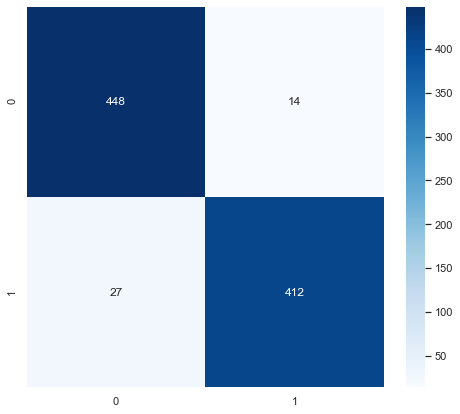

In [212]:
pred_y_rise_tree = rise.predict(test_X_detab)

# print classification report
print(classification_report(test_y_detab.values, pred_y_rise_tree))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y_detab.values, pred_y_rise_tree),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()

Still, `sktime` provides an object that does all of this within a single interface:

In [213]:
from sktime.classification.frequency_based import RandomIntervalSpectralForest as RISE

In [214]:
rise = RISE(n_estimators=20, random_state=SEED)
rise.fit(train_X_detab, train_y_detab)

RandomIntervalSpectralForest(n_estimators=20, random_state=123)

              precision    recall  f1-score   support

        -1.0       0.90      0.94      0.92       462
         1.0       0.93      0.89      0.91       439

    accuracy                           0.91       901
   macro avg       0.91      0.91      0.91       901
weighted avg       0.91      0.91      0.91       901



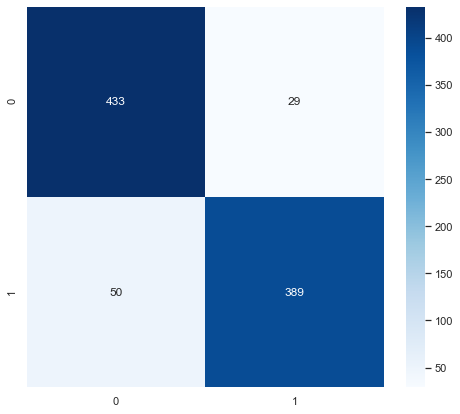

In [215]:
pred_y_rise = rise.predict(test_X_detab)

# print classification report
print(classification_report(test_y_detab.values, pred_y_rise))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y_detab.values, pred_y_rise),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()

And results are slightly worse.

# K-Nearest-Neighbors

[List of Contents](#List-of-Contents)

Now it's a distance approach (or a similarity-based approach, where distance is used as a metric of similarity).
In this case, kNN is extended to accomodate timeseries data (and timeseries as features format).

A common distance metrics in this case is the Dynamic Time Warping distance.

In [216]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [218]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw", )
knn.fit(train_X_detab, train_y_detab)

KNeighborsTimeSeriesClassifier(metric=<built-in function dtw_distance>)

In [219]:
cv_results = cross_validate(knn, train_X_detab, train_y_detab,
                            cv=5, n_jobs=MAX_CORES,
                            scoring=['recall', 'precision', 'f1'])

print('Overall performance:')
print(f"""
    Recall:{np.mean(cv_results['test_recall'])}
    Precision:{np.mean(cv_results['test_precision'])}
    F1:{np.mean(cv_results['test_f1'])}
""")

Overall performance:

    Recall:0.6207771632676575
    Precision:0.6649684276016564
    F1:0.6418822697507282



# Bag of SFA Symbols

This approach is based on representing subsequences of the timeseries data with "words" in order to form a dictionary. Classification is then performed based on how similar are the sets of words for each class.

In [221]:
from sktime.classification.dictionary_based import BOSSEnsemble

In [228]:
boss_clf = BOSSEnsemble(randomised_ensemble=True, n_parameter_samples=50,
                        max_ensemble_size=50, time_limit=20, random_state=SEED)

In [229]:
boss_clf.fit(train_X_detab, train_y_detab)

BOSSEnsemble(max_ensemble_size=50, n_parameter_samples=0, random_state=123,
             randomised_ensemble=True, time_limit=1200)

In [230]:
boss_clf.__dict__

{'randomised_ensemble': True,
 'n_parameter_samples': 0,
 'threshold': 0.92,
 'max_ensemble_size': 50,
 'max_win_len_prop': 1,
 'time_limit': 1200,
 'random_state': 123,
 'classifiers': [BOSSIndividual(random_state=123, save_words=False, window_size=436),
  BOSSIndividual(norm=True, random_state=123, save_words=False, window_size=229,
                 word_length=10),
  BOSSIndividual(norm=True, random_state=123, save_words=False, window_size=136,
                 word_length=14),
  BOSSIndividual(norm=True, random_state=123, save_words=False, window_size=280,
                 word_length=16),
  BOSSIndividual(norm=True, random_state=123, save_words=False, window_size=418),
  BOSSIndividual(random_state=123, save_words=False, window_size=244,
                 word_length=10),
  BOSSIndividual(norm=True, random_state=123, save_words=False, window_size=367),
  BOSSIndividual(random_state=123, save_words=False, window_size=253,
                 word_length=16)],
 'weights': [0.11965432580

              precision    recall  f1-score   support

        -1.0       0.76      0.69      0.72       462
         1.0       0.70      0.77      0.74       439

    accuracy                           0.73       901
   macro avg       0.73      0.73      0.73       901
weighted avg       0.73      0.73      0.73       901



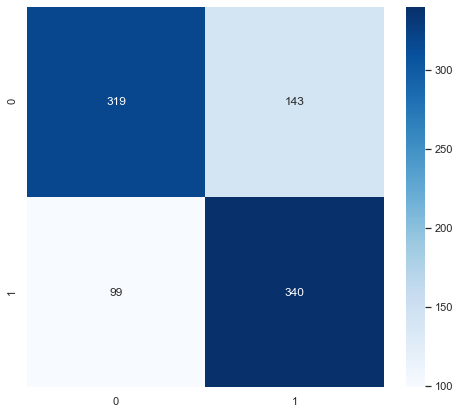

In [231]:
pred_y_boss_clf = boss_clf.predict(test_X_detab)

# print classification report
print(classification_report(test_y_detab.values, pred_y_boss_clf))
# display colored confusion matrix
f = plt.figure(figsize=(8,7))
sns.heatmap(confusion_matrix(test_y_detab.values, pred_y_boss_clf),
            annot=True, cmap='Blues', fmt='.0f',)
plt.show()

# Shapelet Transform

In [33]:
from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform

In [51]:
train_y_arr = np.asarray([*map(str, train_y.values)])
test_y_arr = np.asarray([*map(str, test_y.values)])

In [58]:
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_contract_in_mins = 2

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
TS_LEN = 500
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    min_shapelet_length=50,
    max_shapelet_length=100,
    time_contract_in_mins=time_contract_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(train_X, train_y_arr)

visiting series: 724 (#1)
No more time available! It's been 02:50
Stopping search


ContractedShapeletTransform(max_shapelet_length=100, min_shapelet_length=50,
                            num_candidates_to_sample_per_case=5,
                            random_state=RandomState(MT19937) at 0x7FDCC04B4340,
                            time_contract_in_mins=2, verbose=2)

In [60]:
len(st.shapelets)

1

In [70]:
s = st.shapelets[0].series_id

In [71]:
train_X.iloc[s, 0]

0      0.095449
1      0.291909
2      0.447676
3      0.570341
4      0.685219
         ...   
495   -0.226013
496   -0.041430
497    0.117646
498    0.249074
499    0.346428
Length: 500, dtype: float64

Series ID: 724, start_pos: 172, length: 86, info_gain: 0.058578926064759694, 


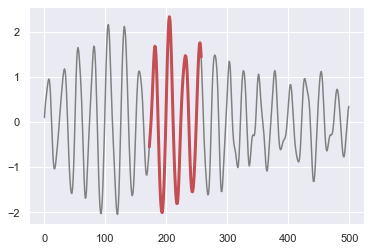

In [78]:
# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(train_X.iloc[s.series_id, 0], 'gray')

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        train_X.iloc[s.series_id,0][s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

In [79]:
test_X_transf = st.transform(test_X)

In [80]:
test_X

,0
3441,0 -0.739337 1 -0.878472 2 -0.91027...
482,0 -1.316146 1 -1.457100 2 -1.46591...
853,0 0.689828 1 0.301674 2 -0.14278...
3036,0 0.963697 1 0.958620 2 0.93785...
2419,0 -0.735360 1 -0.299502 2 0.16547...
...,...
1860,0 -0.708043 1 -0.872668 2 -1.02155...
2430,0 -2.511127 1 -1.453662 2 -0.05853...
3273,0 -1.496735 1 -1.471390 2 -1.31931...
1044,0 -0.483557 1 -0.472586 2 -0.44025...


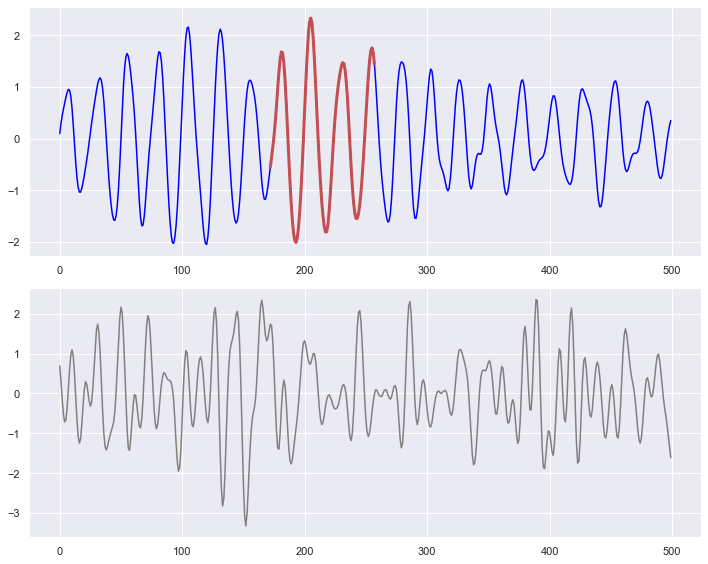

In [92]:
s = st.shapelets[0]

f, axs = plt.subplots(figsize=(10,8), nrows=2)
axs[1].plot(test_X.iloc[2, 0].values, c='gray')
axs[0].plot(train_X.iloc[724, 0].values, c='blue')
axs[0].plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        train_X.iloc[s.series_id,0][s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
plt.tight_layout()
plt.show()

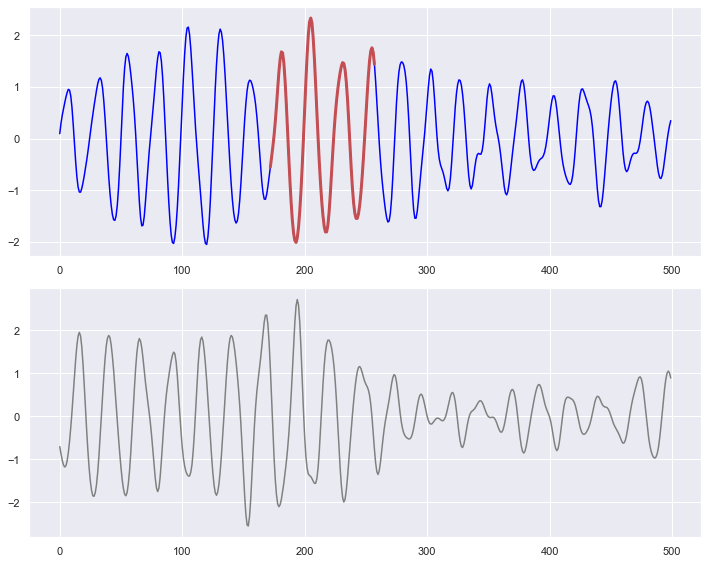

In [93]:
s = st.shapelets[0]

f, axs = plt.subplots(figsize=(10,8), nrows=2)
axs[1].plot(test_X.iloc[896, 0].values, c='gray')
axs[0].plot(train_X.iloc[724, 0].values, c='blue')
axs[0].plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        train_X.iloc[s.series_id,0][s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
plt.tight_layout()
plt.show()

In [95]:
pred_y = st.predict(test_X_transf)

,0
0,0.106076
1,0.456102
2,0.920419
3,0.348571
4,0.144469
...,...
896,0.079734
897,0.806413
898,0.106235
899,0.124561
